In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import distributions as dist , norm
import seaborn as sns
import statsmodels.api as sm
import pandas_market_calendars as pmc
import pandas_datareader as web
from datetime import datetime
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import random

In [257]:
# Import Weatherspoons share prices
today = datetime.today()
years = 5
start = today - relativedelta(years=years)
ticker = 'JDW.L'
df = web.DataReader(ticker, 'yahoo', start, today)

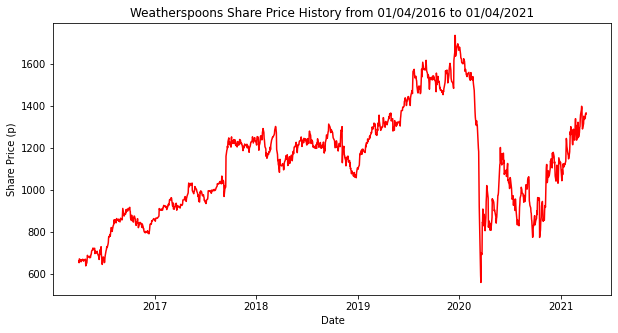

In [258]:
# Share Price against time

From = start
To = today

rest = df[From:To]

plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Share Price (p)')
plt.title(f'Weatherspoons Share Price History from {From.strftime("%d/%m/%Y")} to {To.strftime("%d/%m/%Y")}')
sns.lineplot(x = rest.index, y = rest['Adj Close'], color='red')
plt.show()

In [260]:
# Add daily returns column
df['Daily Return %'] = (df['Adj Close'].pct_change() * 100)
df.dropna(axis=0, how='any', inplace=True)
df.head()

,High,Low,Open,Close,Volume,Adj Close,Daily Return %
Date,,,,,,,
2016-04-05,694.268005,680.0,690.5,682.5,292979.0,653.371582,-1.230089
2016-04-06,703.000000,678.0,683.0,701.5,482243.0,671.560730,2.783890
2016-04-07,704.500000,690.5,702.0,700.0,225386.0,670.124634,-0.213845
2016-04-08,702.500000,687.5,687.5,693.0,156450.0,663.423401,-0.999998
2016-04-11,696.000000,680.5,693.5,695.0,120362.0,665.338074,0.288605


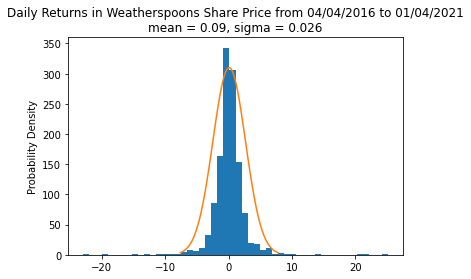

Annual drift of the stock is 22.77%
Annual Volatility of the stock is 40.85 %


In [261]:
From = start
To = today

df_cut = df[From:To]

mean = np.mean(df_cut['Daily Return %'])
std = np.std(df_cut['Daily Return %'])

drift_an = mean * 252
vol = std * np.sqrt(252)

x = np.linspace(mean - 3*std, mean + 3*std, 100)
fig, ax = plt.subplots()
ax.hist(df_cut['Daily Return %'], bins=50)
plt.ylabel('Probability Density')
plt.title(f'Daily Returns in Weatherspoons Share Price from {log_df_cut.index[0].strftime("%d/%m/%Y")} to {log_df_cut.index[-1].strftime("%d/%m/%Y")}\nmean = {round(mean, 3)}, sigma = {round(var, 3)}')
ax.plot(x, 2000 * stats.norm.pdf(x, mean, std))
plt.show()



print(f'Annual drift of the stock is {round(drift_an, 2)}%')
print(f'Annual Volatility of the stock is {round(vol, 2)} %')

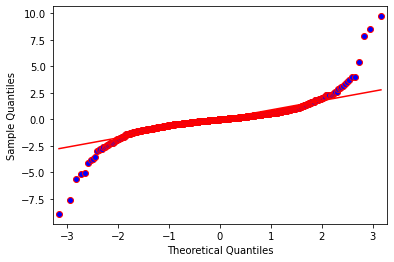

In [262]:
# QQ Plot for normal dist

From = '2016'
To = '2022'

data = df[From:To]['Daily Return %']

sm.qqplot(data, line='r', fit=True, color='r')
plt.show()

In [263]:
# Future Share Price Predictions function

def ds(price, interval, drift, vol, x=1):
    ds = drift * price * interval
    ds_worst = ds - (vol * np.sqrt(interval) * price * x)
    ds_best = ds + (vol * np.sqrt(interval) * price * x)
    s = price + ds
    worst = price + ds_worst
    best = price + ds_best
    return s, worst, best

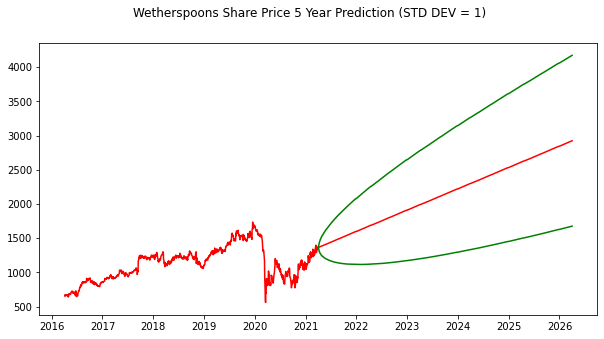

,High,Low,Open,Close,Volume,Adj Close,Daily Return %
Date,,,,,,,
2016-04-05,694.268005,680.0,690.5,682.5,292979.0,653.371582,-1.230089
2016-04-06,703.000000,678.0,683.0,701.5,482243.0,671.560730,2.783890
2016-04-07,704.500000,690.5,702.0,700.0,225386.0,670.124634,-0.213845
2016-04-08,702.500000,687.5,687.5,693.0,156450.0,663.423401,-0.999998
2016-04-11,696.000000,680.5,693.5,695.0,120362.0,665.338074,0.288605


In [264]:
cal = pmc.get_calendar('LSE')
future = today + relativedelta(years=5)
schedule = cal.schedule(today, future)
dates = pmc.date_range(schedule, frequency='1D')

pred = []
maximum = []
minimum = []
dec_drift_an = drift_an / 100
dec_vol = vol / 100
std_devs = 1
for i in range(len(dates)):
    avg, worst, best = ds(df.iloc[-1]['Adj Close'], i/252, dec_drift_an, dec_vol, std_devs)
    pred.append(avg)
    maximum.append(best)
    minimum.append(worst)

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(f'Wetherspoons Share Price 5 Year Prediction (STD DEV = {std_devs})')
ax.plot(df.index, df['Adj Close'], color='r')
ax.plot(dates, pred, color='r')
ax.plot(dates, maximum, color='g')
ax.plot(dates, minimum, color='g')
plt.show()
df.head()

A £1000000 investment in JDW.L shares on 2016-04-04 00:00:00 would have purchased 151169.6 shares
You could sell these shares today for £2071930.3, a 107.19% return on investment!
At the stock's lowest price on 19/03/2020, your investment would be worth £845793.83
At the stock's highest price on 17/12/2019, your investment would be worth £2621280.61
If you had left the money in a savings account at 0.77% interest p.a., it would now be worth £1039235.19,a 3.92% return on investment!


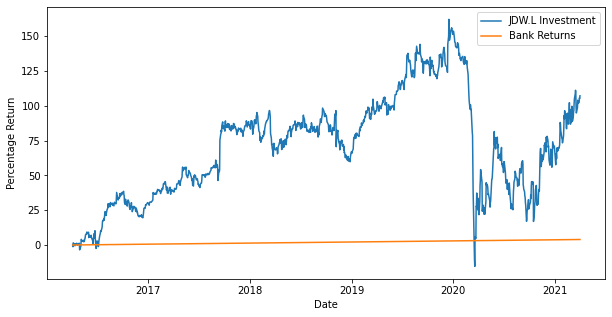

In [247]:
# £1M Investment Breakdown

investment = 1000000
investment_pence = investment * 100
date_bought = df.index[0]

# Import LIBOR interest rate data
LIBOR = 'LIBOR.csv'
lib_df = pd.read_csv(LIBOR, index_col='DATE')
lib_df.index = pd.to_datetime(lib_df.index)
interest_rate = float(lib_df.loc[lib_df.index >= date_bought].mean())

shares_bought = investment_pence / df.loc[date_bought,'Adj Close']
current_value = shares_bought * df.iloc[-1]['Adj Close'] / 100
per_return = (current_value - investment) / investment * 100
minimum_val = shares_bought * df.loc[date_bought:, 'Adj Close'].min() / 100
minimum_val_date = df['Adj Close'].idxmin()
maximum_val = shares_bought * df.loc[date_bought:, 'Adj Close'].max() / 100
maximum_val_date = df['Adj Close'].idxmax()
bank_value = investment * np.exp((interest_rate/100) * 5)
bank_return = (bank_value - investment) / investment * 100

print(f'A £{investment} investment in {ticker} shares on {date_bought} would have purchased {round(shares_bought,1)} shares')
print(f'You could sell these shares today for £{round(current_value,2)}, a {round(per_return,2)}% return on investment!')
print(f'At the stock\'s lowest price on {minimum_val_date.strftime("%d/%m/%Y")}, your investment would be worth £{round(minimum_val,2)}')
print(f'At the stock\'s highest price on {maximum_val_date.strftime("%d/%m/%Y")}, your investment would be worth £{round(maximum_val,2)}')
print(f'If you had left the money in a savings account at {round(interest_rate,2)}% interest p.a., it would now be worth £{round(bank_value,2)},a {round(bank_return,2)}% return on investment!')

# Plotting

percentage_return = list(((df['Adj Close'] / df.iloc[0]['Adj Close']) - 1) * 100)
bank_return_daily = []
for i in range(len(df.index)):
    bank_return_daily.append((np.exp((interest_rate/100) * i/252) - 1) * 100)
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('Date')
ax.set_ylabel('Percentage Return')
ax.plot(df.index, percentage_return, label=f'{ticker} Investment')
ax.plot(df.index, bank_return_daily, label='Bank Returns')
ax.legend()
plt.show()

In [267]:
# Lognormal Analysis

log_df['Log Returns'] = np.log(log_df['Adj Close'].pct_change() + 1)
log_df.dropna(how='any', axis=0, inplace=True)
log_df.head()

,High,Low,Open,Close,Volume,Adj Close,Adj Close (Previous Day),Daily Return %,Log Returns
Date,,,,,,,,,
2016-04-13,697.0,686.500000,688.0,695.5,192069.0,665.816711,657.679565,0.012373,0.012297
2016-04-14,696.5,689.150024,693.0,693.5,115543.0,663.902161,665.816711,-0.002875,-0.002880
2016-04-15,699.0,689.000000,693.0,694.0,99593.0,664.380798,663.902161,0.000721,0.000721
2016-04-18,700.0,686.000000,688.0,699.5,246132.0,669.646057,664.380798,0.007925,0.007894
2016-04-19,701.0,683.000000,683.0,699.0,294356.0,669.167297,669.646057,-0.000715,-0.000715


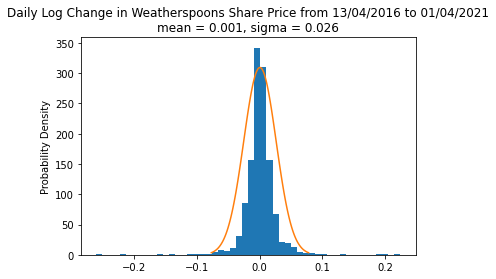

Annual drift of the stock is 14.7%
Annual Volatility of the stock is 40.94%


In [268]:
From = start
To = today

log_df_cut = log_df[From:To]
mean = np.mean(log_df_cut['Log Returns'])
std = np.std(log_df_cut['Log Returns'])

x = np.linspace(mean - 3*std, mean + 3*std, 100)

fig, ax = plt.subplots()
ax.hist(log_df_cut['Log Returns'], bins=50)
plt.ylabel('Probability Density')
plt.title(f'Daily Log Change in Weatherspoons Share Price from {log_df_cut.index[0].strftime("%d/%m/%Y")} to {log_df_cut.index[-1].strftime("%d/%m/%Y")}\nmean = {round(mean, 3)}, sigma = {round(std, 3)}')
ax.plot(x, 20 * stats.norm.pdf(x, mean, std))
plt.show()

drift_an = mean * 252
vol = std * np.sqrt(252)

print(f'Annual drift of the stock is {round(drift_an * 100, 2)}%')
print(f'Annual Volatility of the stock is {round(vol * 100, 2)}%')

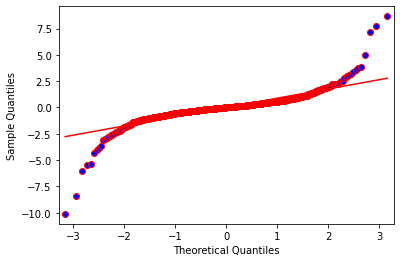

In [269]:
# Log QQ Plot

From = start
To = today

data = log_df[From:To]['Log Returns']

sm.qqplot(data, line='r', fit=True, color='r')
plt.show()

In [270]:
def share_price(initial, drift, vol, delta, x=1):
    s = np.exp(np.log(initial) + (drift_an * delta))
    best = np.exp(np.log(initial) + (drift_an * delta) + (vol * x * np.sqrt(delta)))
    worst = np.exp(np.log(initial) + (drift_an * delta) - (vol * x * np.sqrt(delta)))
    return s, best, worst

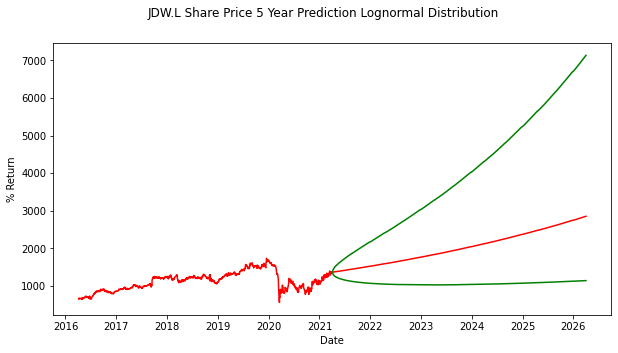

In [312]:

price = []
best = []
worst = []
initial = df.iloc[-1]['Adj Close']
std_devs = 1
for i in range(len(dates)):
    price.append(share_price(initial, drift_an, vol, i/252, std_devs)[0])
    best.append(share_price(initial, drift_an, vol, i/252, std_devs)[1])
    worst.append(share_price(initial, drift_an, vol, i/252, std_devs)[2])
fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(f'{ticker} Share Price 5 Year Prediction Lognormal Distribution')
ax.plot(df.index, df['Adj Close'], color='r')
ax.plot(dates, price, color='r')
ax.plot(dates, best, color='g')
ax.plot(dates, worst, color='g')
ax.set_xlabel('Date')
ax.set_ylabel('% Return')
plt.show()

In [310]:
# Monte Carlo analysis
s = (df['Daily Return %'] / 100) + 1

simulated = pd.DataFrame([np.array(random.choices(s, k=len(dates))).cumprod() for x in range(1000)]).T
simulated.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.999187,1.009281,0.995916,1.005947,0.989658,1.000000,1.043058,1.005047,0.989658,1.003367,...,0.996787,1.012479,1.032397,1.036885,1.011146,0.993533,0.992574,0.993062,0.936159,1.016962
1,1.027022,0.996105,1.025740,0.992815,1.008945,1.009101,1.034398,1.000051,0.986478,0.995372,...,1.023586,1.025114,1.009430,1.039287,1.023338,0.997399,1.001340,1.002272,0.928427,1.006303
2,1.028896,1.011054,1.031985,1.007032,1.070446,0.996620,1.039493,1.103607,1.001083,0.994520,...,1.028499,1.020178,1.013877,1.046262,1.115866,0.997399,1.015679,1.011214,0.930876,1.020887
3,1.007274,0.984303,1.031319,0.996791,1.064914,1.013596,1.039493,1.106196,0.976776,0.998037,...,1.035448,1.016927,1.019697,1.048495,1.117571,0.993511,1.019563,1.015172,0.944040,1.026604
4,1.011549,0.962226,1.016985,1.026009,1.043630,0.997136,1.055124,1.101699,1.017512,0.999660,...,1.041724,1.012574,1.027913,1.100350,1.096318,0.993511,1.014847,1.026533,0.944860,0.985342


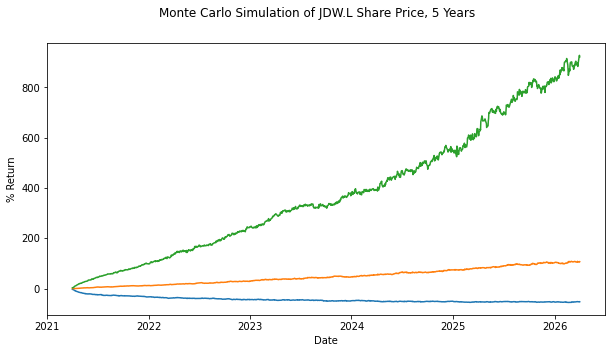

In [313]:
quantiles = simulated.quantile([0.05, 0.5, 0.95], axis=1).T
quantiles = (quantiles - 1) * 100

fig, ax = plt.subplots(figsize=(10,5))
fig.suptitle(f'Monte Carlo Simulation of {ticker} Share Price, 5 Years')
ax.plot(dates, quantiles)
ax.set_xlabel('Date')
ax.set_ylabel('% Return')
plt.show()